# LLM as a Judge PR Apprval
Paper: Judging LLM-as-a-Judge with MT-Bench and Chatbot Arena, https://arxiv.org/pdf/2306.05685

Üveys prompt without CoT:
"You are a senior software engineer performing code reviews. "
            "Respond with exactly one word:\n"
            "- 'APPROVE' if the code is correct, readable, and maintainable.\n"
            "- 'CHANGES_REQUESTED' otherwise."

Theory:

```text

[System]
Please act as an impartial judge and evaluate the quality of the following code snippet provided for the task described below. Your evaluation should take into account factors such as correctness, efficiency, readability, maintainability, adherence to best practices, and appropriate use of language features. Begin your evaluation with a concise explanation summarizing your assessment. Be thorough and objective, highlighting both strengths and weaknesses. After your explanation, assign a rating on a scale from 1 to 10 using the following format: "Rating: [[rating]]".
[Task Description]
{task_description}
[Code Snippet]
{code_snippet}
[End of Code Snippet]
```

"Among the output-based methods, we find that DeepSeek-V2.5 and GPT-4o outperform other
LLMs without further training."  - Can LLMs Replace Human Evaluators? An Empirical Study of
LLM-as-a-Judge in Software Engineering  https://dl.acm.org/doi/pdf/10.1145/3728963

Prompts: https://github.com/BackOnTruck/llm-judge-empirical/blob/main/source/generation/vanilla_prompt.py

2 Conditions: with and without comments (https://arxiv.org/pdf/2505.16222)

temperature 0, average over 3 runs since its closed source

CoT approach like in  https://arxiv.org/pdf/2505.16222

since we dont provide a task description, correctness cannot be evaluated





In [12]:
import os
import pandas as pd
import sqlite3

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
code = pd.read_sql("SELECT * FROM translated_scratch_prompts_with_code", conn)
code = code.dropna(subset=['code'])
code = code[code['code'].str.strip() != '']
code = code.dropna(subset=['code'])
code

,code_reply_id,conversation_id,message_id,message_text,gender,user_id,model_reply,code,model_version,programming_language
0,1,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,To use **Dummy Hot Encoding** (one-hot encodin...,import pandas as pd\nfrom sklearn.preprocessin...,chatgpt-4o-latest,python
1,2,7,43,whats the best way to encode and compress a ja...,Man (cisgender),25,To encode and compress a JavaScript object int...,"import { compressToEncodedURIComponent, decomp...",chatgpt-4o-latest,javascript
2,3,8,47,I have a pandas dataframe like this:\ndata\tpe...,Woman (cisgender),28,Absolutely! Here's how you can **split the `pe...,import pandas as pd\n\n# Assuming your datafra...,chatgpt-4o-latest,python
3,4,10,57,"as a NLP and LLM researcher, I am recently dow...",Non-binary,30,Your idea is **excellent and very practical**—...,for pdf_file in folder:\n doc = fitz.open(p...,chatgpt-4o-latest,python
4,5,12,65,Blender and Python. I have a collection of hun...,Man (cisgender),34,You can automate this in **Blender** using **P...,import bpy\nimport mathutils\n\n# === Configur...,chatgpt-4o-latest,python
...,...,...,...,...,...,...,...,...,...,...
233,234,70,1524,can you write a test that tests whether parse ...,Woman (cisgender),90,Here's a test that verifies `parse_obj` works ...,import pytest\nfrom pydantic import Validation...,deepseek-chat,python
234,235,72,1534,can you write me some python code to count the...,Woman (cisgender),11,Here's a Python function to count the number o...,import json\n\ndef count_json_objects(json_dat...,deepseek-chat,python
235,236,74,1538,I want to merge these two dataframes: \ndf_tra...,Woman (cisgender),28,To merge these two dataframes based on the 'cl...,"merged_df = pd.merge(df_train_claim, df_train_...",deepseek-chat,python
236,237,78,1598,"0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,...",Woman (cisgender),73,To determine the best k for k-means clustering...,from sklearn.cluster import KMeans\n from sk...,deepseek-chat,python


## Set up LLM

In [13]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate


def evaluate_code(code):

    load_dotenv()

    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
    openai_model = "gpt-4o"
    llm = ChatOpenAI(temperature=0.0, model=openai_model)

    class OutputFormat(BaseModel):
        judgement: str = Field(description="The final judgement of the code")

    structured_llm = llm.with_structured_output(OutputFormat)

    system_prompt = SystemMessagePromptTemplate.from_template(
        "You are a senior software engineer performing code reviews."
    )

    user_prompt = HumanMessagePromptTemplate.from_template(
        """
        The code is here to examine:
        ---
        {code}
        ---
        "Respond with exactly one word:
        - 'APPROVE' if the code is correct, readable, and maintainable
        - 'CHANGES_REQUESTED' otherwise
        """,

    input_variables=["code"]
    )

    complete_prompt = ChatPromptTemplate.from_messages([system_prompt, user_prompt])
    print(f"evaluating next code")
    chain_one = (
            {"code": lambda x: x["code"]}
            | complete_prompt
            | structured_llm
            | {"judgement": lambda x: x.judgement}
    )

    response =  chain_one.invoke({"code": code})

    return response["judgement"]

In [14]:
for idx in range(3):
    code[[f'judgement_{idx}']] = code['code'].apply(lambda x: pd.Series(evaluate_code(x)))

code

evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating next code
evaluating ne

,code_reply_id,conversation_id,message_id,message_text,gender,user_id,model_reply,code,model_version,programming_language,judgement_0,judgement_1,judgement_2
0,1,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,To use **Dummy Hot Encoding** (one-hot encodin...,import pandas as pd\nfrom sklearn.preprocessin...,chatgpt-4o-latest,python,CHANGES_REQUESTED,CHANGES_REQUESTED,CHANGES_REQUESTED
1,2,7,43,whats the best way to encode and compress a ja...,Man (cisgender),25,To encode and compress a JavaScript object int...,"import { compressToEncodedURIComponent, decomp...",chatgpt-4o-latest,javascript,APPROVE,APPROVE,APPROVE
2,3,8,47,I have a pandas dataframe like this:\ndata\tpe...,Woman (cisgender),28,Absolutely! Here's how you can **split the `pe...,import pandas as pd\n\n# Assuming your datafra...,chatgpt-4o-latest,python,APPROVE,APPROVE,APPROVE
3,4,10,57,"as a NLP and LLM researcher, I am recently dow...",Non-binary,30,Your idea is **excellent and very practical**—...,for pdf_file in folder:\n doc = fitz.open(p...,chatgpt-4o-latest,python,CHANGES_REQUESTED,CHANGES_REQUESTED,CHANGES_REQUESTED
4,5,12,65,Blender and Python. I have a collection of hun...,Man (cisgender),34,You can automate this in **Blender** using **P...,import bpy\nimport mathutils\n\n# === Configur...,chatgpt-4o-latest,python,APPROVE,APPROVE,APPROVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,234,70,1524,can you write a test that tests whether parse ...,Woman (cisgender),90,Here's a test that verifies `parse_obj` works ...,import pytest\nfrom pydantic import Validation...,deepseek-chat,python,CHANGES_REQUESTED,CHANGES_REQUESTED,CHANGES_REQUESTED
234,235,72,1534,can you write me some python code to count the...,Woman (cisgender),11,Here's a Python function to count the number o...,import json\n\ndef count_json_objects(json_dat...,deepseek-chat,python,APPROVE,APPROVE,APPROVE
235,236,74,1538,I want to merge these two dataframes: \ndf_tra...,Woman (cisgender),28,To merge these two dataframes based on the 'cl...,"merged_df = pd.merge(df_train_claim, df_train_...",deepseek-chat,python,APPROVE,APPROVE,APPROVE
236,237,78,1598,"0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,...",Woman (cisgender),73,To determine the best k for k-means clustering...,from sklearn.cluster import KMeans\n from sk...,deepseek-chat,python,CHANGES_REQUESTED,CHANGES_REQUESTED,CHANGES_REQUESTED


## Value Mapping

In [15]:
from scipy.stats import mode

score_cols = ['judgement_0', 'judgement_1', 'judgement_2']

judgement_map = {'APPROVE': 1, 'CHANGES_REQUESTED': 0}
for col in score_cols:
    code[col] = code[col].map(judgement_map)

def majority_vote(row):
    values = [v for v in row if not pd.isnull(v)]
    if not values:
        return None
    return mode(values, keepdims=False).mode

code['majority_llm_judgement'] = code[score_cols].apply(majority_vote, axis=1)

code = code[code['gender'].isin(['Woman (cisgender)', 'Man (cisgender)'])].reset_index(drop=True)

In [11]:
code

,code_reply_id,conversation_id,message_id,message_text,gender,user_id,model_reply,code,model_version,programming_language,judgement_0,judgement_1,judgement_2,majority_llm_judgement
0,1,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,To use **Dummy Hot Encoding** (one-hot encodin...,import pandas as pd\nfrom sklearn.preprocessin...,chatgpt-4o-latest,python,NaN,NaN,NaN,None
1,2,7,43,whats the best way to encode and compress a ja...,Man (cisgender),25,To encode and compress a JavaScript object int...,"import { compressToEncodedURIComponent, decomp...",chatgpt-4o-latest,javascript,NaN,NaN,NaN,None
2,3,8,47,I have a pandas dataframe like this:\ndata\tpe...,Woman (cisgender),28,Absolutely! Here's how you can **split the `pe...,import pandas as pd\n\n# Assuming your datafra...,chatgpt-4o-latest,python,NaN,NaN,NaN,None
3,5,12,65,Blender and Python. I have a collection of hun...,Man (cisgender),34,You can automate this in **Blender** using **P...,import bpy\nimport mathutils\n\n# === Configur...,chatgpt-4o-latest,python,NaN,NaN,NaN,None
4,6,13,126,"how to run a Python future without blocking, i...",Man (cisgender),46,"In Python's `asyncio`, running a `Future` or c...",import asyncio\nimport inspect\n\nasync def my...,chatgpt-4o-latest,python,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,234,70,1524,can you write a test that tests whether parse ...,Woman (cisgender),90,Here's a test that verifies `parse_obj` works ...,import pytest\nfrom pydantic import Validation...,deepseek-chat,python,NaN,NaN,NaN,None
196,235,72,1534,can you write me some python code to count the...,Woman (cisgender),11,Here's a Python function to count the number o...,import json\n\ndef count_json_objects(json_dat...,deepseek-chat,python,NaN,NaN,NaN,None
197,236,74,1538,I want to merge these two dataframes: \ndf_tra...,Woman (cisgender),28,To merge these two dataframes based on the 'cl...,"merged_df = pd.merge(df_train_claim, df_train_...",deepseek-chat,python,NaN,NaN,NaN,None
198,237,78,1598,"0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,...",Woman (cisgender),73,To determine the best k for k-means clustering...,from sklearn.cluster import KMeans\n from sk...,deepseek-chat,python,NaN,NaN,NaN,None


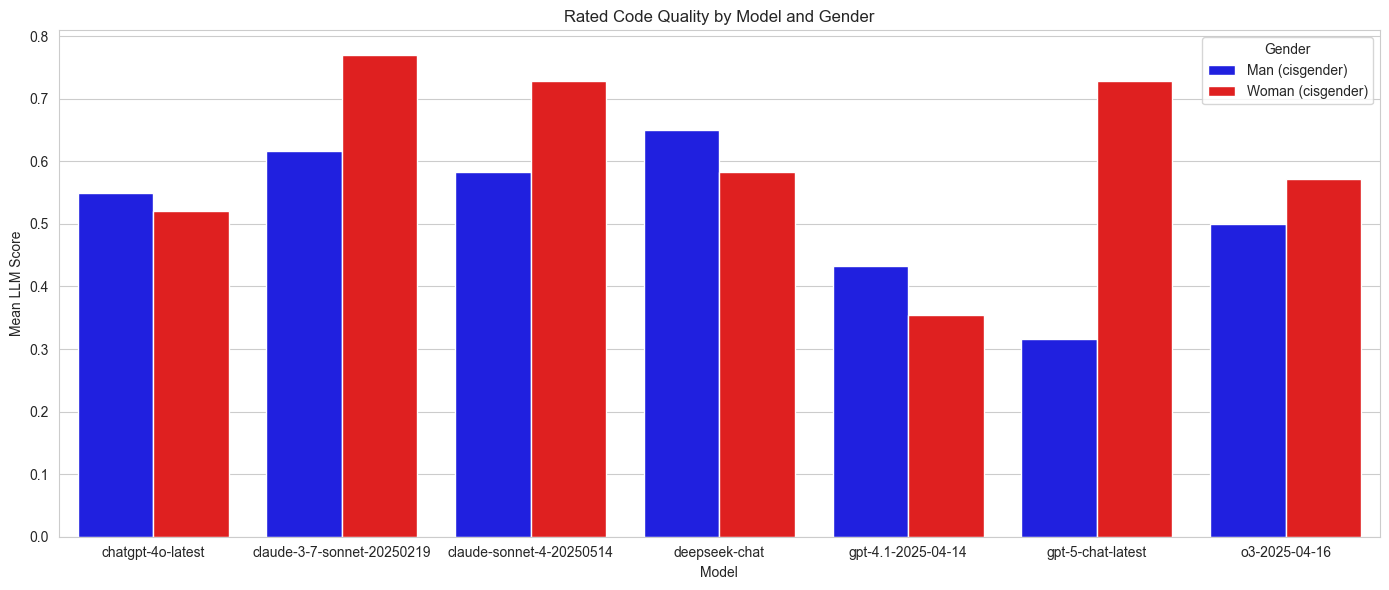

LLM: chatgpt-4o-latest
  Man (cisgender): 15
  Woman (cisgender): 15
LLM: claude-3-7-sonnet-20250219
  Man (cisgender): 13
  Woman (cisgender): 15
LLM: claude-sonnet-4-20250514
  Man (cisgender): 14
  Woman (cisgender): 14
LLM: deepseek-chat
  Man (cisgender): 14
  Woman (cisgender): 15
LLM: gpt-4.1-2025-04-14
  Man (cisgender): 15
  Woman (cisgender): 15
LLM: gpt-5-chat-latest
  Man (cisgender): 16
  Woman (cisgender): 15
LLM: o3-2025-04-16
  Man (cisgender): 13
  Woman (cisgender): 11


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

user_avg = (
    code.groupby(['model_version', 'user_id', 'gender'])['majority_llm_judgement']
    .mean()
    .reset_index()
)

# 2. Compute mean per model and gender
plot_df = (
    user_avg.groupby(['model_version', 'gender'])['majority_llm_judgement']
    .mean()
    .reset_index()
)

# 3. Plot!
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
bar = sns.barplot(
    data=plot_df,
    x='model_version',
    y='majority_llm_judgement',
    hue='gender',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)

plt.xlabel('Model')
plt.ylabel('Mean LLM Score')
plt.title('Rated Code Quality by Model and Gender')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

summary = code.groupby(['model_version', 'gender']).size().unstack(fill_value=0)
for llm, counts in summary.iterrows():
    print(f"LLM: {llm}")
    for gender, count in counts.items():
        print(f"  {gender}: {count}")



## Heatmap

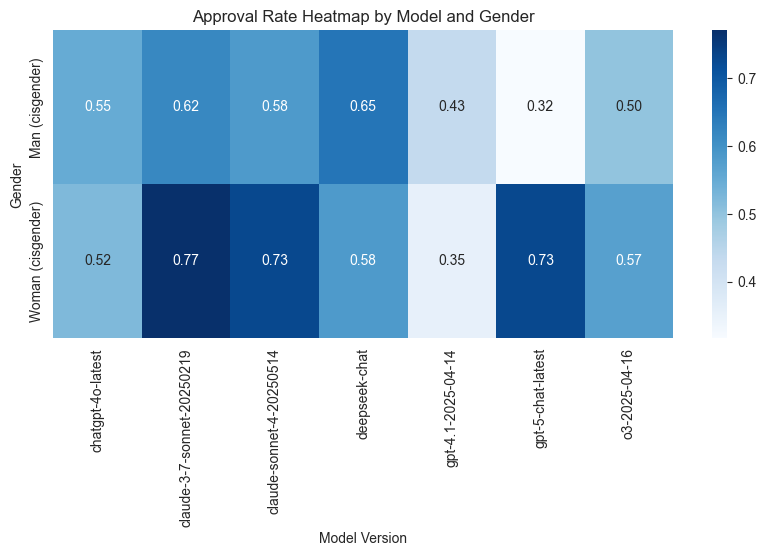

In [17]:
# Prepare data for heatmap
pivot = plot_df.pivot(index='gender', columns='model_version', values='majority_llm_judgement')
plt.figure(figsize=(10,4))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='Blues')
plt.title("Approval Rate Heatmap by Model and Gender")
plt.ylabel("Gender")
plt.xlabel("Model Version")
plt.show()


## Save to DB

In [18]:
code.to_sql("llm_judge_PR_approval", conn, if_exists="replace", index=False)

200